In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import solve_ivp, odeint
import math
import pandas as pd
from io import StringIO
from scipy.interpolate import interp1d

# Initial Conditions
T0 = 100000
I0 = 0
L0 = 0
V0 = 200

# Parameters
d = 0.01
beta = 0.0000002
f = 0.001
a = 0.2
delta_I = 1 
delta_L = 0.0039
c = 23
p = 4000
lambda_param = 1000  # T0 * d
Omega = 1

t_initial = 0
t_final = 100

t = np.linspace(t_initial, t_final, 1000)



geom = dde.geometry.TimeDomain(t_initial, t_final)

Y0 = [T0, I0, L0, V0]

def system(Y, t):
    T, I, L, V = Y
    dT_dt = lambda_param - d * T - Omega * beta * V * T
    dI_dt = (1 - f) * Omega * beta * V * T + a * L - delta_I *   I
    dL_dt = f * Omega * beta * V * T - a * L - delta_L * L
    dV_dt = Omega * p * I - c * V
    return [dT_dt, dI_dt, dL_dt, dV_dt]

t = np.linspace(t_initial, t_final, 1000)

solution = odeint(system, Y0, t)
T, I, L, V = solution.T



Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
interp_T = interp1d(t, T, kind='cubic', fill_value='extrapolate')
interp_I = interp1d(t, I, kind='cubic', fill_value='extrapolate')
interp_L = interp1d(t, L, kind='cubic', fill_value='extrapolate')
interp_V = interp1d(t, V, kind='cubic', fill_value='extrapolate')

# Corrected Function to Ensure Proper Shape
def func(t):
    T_val = interp_T(t)
    I_val = interp_I(t)
    L_val = interp_L(t)
    V_val = interp_V(t)
    return np.column_stack((T_val, I_val, L_val, V_val))





In [50]:
def ode(t, Y):
    T = Y[:, 0:1]
    I = Y[:, 1:2]
    L = Y[:, 2:3]
    V = Y[:, 3:4]
    
    dT_dt = dde.grad.jacobian(Y, t, i=0)
    dI_dt = dde.grad.jacobian(Y, t, i=1)
    dL_dt = dde.grad.jacobian(Y, t, i=2)
    dV_dt = dde.grad.jacobian(Y, t, i=3)
    
    return [
        dT_dt - (lambda_param - d * T - Omega * beta * V * T),
        dI_dt - ((1 - f) * Omega * beta * V * T + a * L - delta_I * I),
        dL_dt - (f * Omega * beta * V * T - a * L - delta_L * L),
        dV_dt - (Omega * p * I - c * V)
    ]

def boundary(_, on_initial):
    return on_initial

ic_T = dde.icbc.IC(geom, lambda x: T0, boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda x: I0, boundary, component=1)
ic_L = dde.icbc.IC(geom, lambda x: L0, boundary, component=2)
ic_V = dde.icbc.IC(geom, lambda x: V0, boundary, component=3)

data = dde.data.PDE(
    geom,
    ode,
    [ic_T, ic_I, ic_L, ic_V],
    num_domain=5000,
    num_boundary=2,
    solution=func,
    num_test=1000
)

In [51]:
neurons = 64
layers = 3
activation = "relu"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [4], activation, initializer)

In [52]:
model = dde.Model(data, net)

In [18]:
model.compile("adam", lr=0.001, loss_weights=[1e-6, 1, 1, 1e-8, 1e-10, 1, 1, 1e-4])
losshistory, train_state = model.train(iterations=15000, display_every=5000)

Compiling model...
'compile' took 0.000630 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
25000     [5.23e+00, 2.40e-01, 2.79e-02, 9.00e-03, 7.48e-07, 3.74e+00, 2.95e-01, 2.28e-04]    [5.22e+00, 2.36e-01, 2.80e-02, 8.91e-03, 7.48e-07, 3.74e+00, 2.95e-01, 2.28e-04]    []  
30000     [2.39e-01, 2.45e-02, 1.59e-02, 6.87e-02, 5.33e-02, 5.87e-03, 8.54e-02, 5.38e-03]    [2.40e-01, 2.39e-02, 1.58e-02, 6.86e-02, 5.33e-02, 5.87e-03, 8.54e-02, 5.38e-03]    []  
35000     [1.05e-01, 9.31e-02, 1.61e-02, 8.06e-02, 1.04e-01, 7.12e-02, 1.22e-01, 3.09e-03]    [1.05e-01, 9.33e-02, 1.60e-02, 8.06e-02, 1.04e-01, 7.12e-02, 1.22e-01, 3.09e-03]    []  
40000     [2.17e-02, 9.54e-03, 5.05e-03, 4.78e-02, 9.19e-02, 5.57e-05, 1.19e-05, 1.85e-03]    [2.15e-02, 9.44e-03, 4.92e-03, 4.77e-02, 9.19e-02, 5.57e-05, 1.19e-05, 1.85e-03]    []  

Best model a

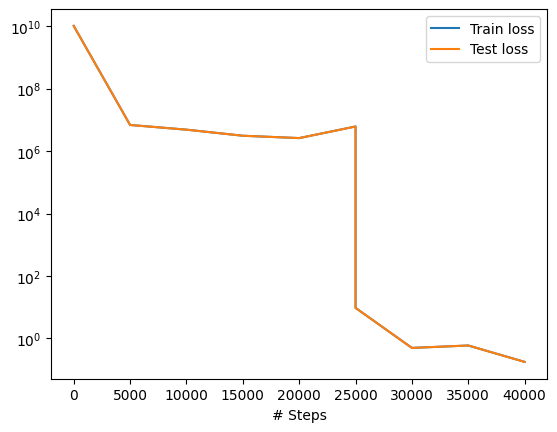

In [19]:
dde.utils.external.plot_loss_history(losshistory)


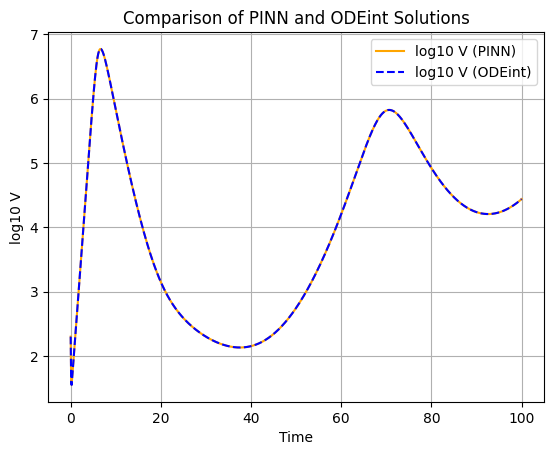

In [58]:
t_plot = np.linspace(t_initial, t_final, 1000)


T_pinn = func(t_plot)[:, 0]
I_pinn = func(t_plot)[:, 1]
L_pinn = func(t_plot)[:, 2]
V_pinn = func(t_plot)[:, 3]

# Plot PINN Solution
plt.plot(t, np.log10(V_pinn), color="orange", label="log10 V (PINN)")

# Plot ODEint Solution
plt.plot(t, np.log10(V), color="blue", label="log10 V (ODEint)", linestyle='--')

# Adding Labels and Title
plt.xlabel("Time")
plt.ylabel("log10 V")
plt.title("Comparison of PINN and ODEint Solutions")

# Adding Legend
plt.legend()

# Adding Grid
plt.grid(True)

# Display the Plot
plt.show()


#epsilon is 0 until a certain point. epsilon is 0.9 after a certain point, or estimate
#Have data for v for aboove line

#at point m at end of graph haev L(tm)* 10e6 /(L(tm) + I(tm) + T(tm))

In [496]:
# Non-Dimensionalized ODE System

import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import solve_ivp, odeint
import math
import pandas as pd
from io import StringIO
from scipy.interpolate import interp1d

# Scaling Parameters
d = 0.01
lambda_param = 1000  # T0 * d
t_ref = 1 / d  # Time scaling

# Define dimensionless parameters
alpha = 0.2 / d
beta = 1 / d
gamma = 0.0039 / d
f = 0.001
Omega = 1
c = 23
p = 4000
beta_param = 0.0000002

# Initial Conditions (Non-Dimensional)
T0 = 100000
I0 = 0
L0 = 0
V0 = 200

# Scaling for State Variables
T_ref = lambda_param / d
V_ref = (Omega * p * (Omega * beta_param * (V0) * T_ref / beta)) / c
I_ref = (Omega * beta_param * V_ref * T_ref) / beta
L_ref = (f * Omega * beta_param * V_ref * T_ref) / (alpha + gamma)

# Dimensionless Initial Conditions
T0_star = T0 / T_ref
I0_star = I0 / I_ref
L0_star = L0 / L_ref
V0_star = V0 / V_ref



geom = dde.geometry.TimeDomain(tau_initial, tau_final)

Y0 = [T0_star, I0_star, L0_star, V0_star]

def system_star(Y, tau):
    T_star, I_star, L_star, V_star = Y
    dT_star_dtau = 1 - T_star - V_star * T_star
    dI_star_dtau = (1 - f) * V_star * T_star + alpha * L_star - I_star
    dL_star_dtau = f * V_star * T_star - beta * L_star - gamma * L_star
    dV_star_dtau = I_star - V_star
    return [dT_star_dtau, dI_star_dtau, dL_star_dtau, dV_star_dtau]

tau = np.linspace(tau_initial, tau_final, 1000)

# Original ODE Solution for Comparison
solution_star = odeint(system_star, Y0, tau)
T_star, I_star, L_star, V_star = solution_star.T

# Interpolation of Solutions
interp_T_star = interp1d(tau, T_star, kind='cubic', fill_value='extrapolate')
interp_I_star = interp1d(tau, I_star, kind='cubic', fill_value='extrapolate')
interp_L_star = interp1d(tau, L_star, kind='cubic', fill_value='extrapolate')
interp_V_star = interp1d(tau, V_star, kind='cubic', fill_value='extrapolate')

def func_star(tau):
    T_val = interp_T_star(tau)
    I_val = interp_I_star(tau)
    L_val = interp_L_star(tau)
    V_val = interp_V_star(tau)
    return np.hstack((T_val, I_val, L_val, V_val))

def ode_star(tau, Y):
    T_star = Y[:, 0:1]
    I_star = Y[:, 1:2]
    L_star = Y[:, 2:3]
    V_star = Y[:, 3:4]
    
    dT_star_dtau = dde.grad.jacobian(Y, tau, i=0)
    dI_star_dtau = dde.grad.jacobian(Y, tau, i=1)
    dL_star_dtau = dde.grad.jacobian(Y, tau, i=2)
    dV_star_dtau = dde.grad.jacobian(Y, tau, i=3)
    
    return [
        dT_star_dtau - (1 - T_star - V_star * T_star),
        dI_star_dtau - ((1 - f) * V_star * T_star + alpha * L_star - I_star),
        dL_star_dtau - (f * V_star * T_star - beta * L_star - gamma * L_star),
        dV_star_dtau - (I_star - V_star)
    ]

def boundary(_, on_initial):
    return on_initial

# Initial Conditions in Dimensionless Form
ic_T_star = dde.icbc.IC(geom, lambda x: T0_star, boundary, component=0)
ic_I_star = dde.icbc.IC(geom, lambda x: I0_star, boundary, component=1)
ic_L_star = dde.icbc.IC(geom, lambda x: L0_star, boundary, component=2)
ic_V_star = dde.icbc.IC(geom, lambda x: V0_star, boundary, component=3)

data_star = dde.data.PDE(
    geom,
    ode_star,
    [ic_T_star, ic_I_star, ic_L_star, ic_V_star],
    num_domain=3000,
    num_boundary=2,
    solution=func_star,
    num_test=1000
)

neurons = 64
layers = 3
activation = "relu"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [4], activation, initializer)

model = dde.Model(data_star, net)

model.compile("adam", lr=0.001, loss_weights=[1e-6, 1, 1, 1e-8, 1e-10, 1, 1, 1e-4])
losshistory, train_state = model.train(iterations=25000, display_every=5000)


Compiling model...
'compile' took 0.000717 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [9.44e-07, 8.15e-02, 7.40e-01, 5.89e-11, 1.00e-10, 0.00e+00, 0.00e+00, 8.27e-02]    [9.44e-07, 8.15e-02, 7.41e-01, 5.89e-11, 1.00e-10, 0.00e+00, 0.00e+00, 8.27e-02]    []  
5000      [1.05e-06, 7.91e-06, 1.04e-05, 5.61e-07, 1.00e-10, 1.39e-10, 1.35e-08, 1.13e-07]    [1.05e-06, 7.74e-06, 1.08e-05, 5.61e-07, 1.00e-10, 1.39e-10, 1.35e-08, 1.13e-07]    []  
10000     [1.00e-06, 2.90e-06, 2.65e-06, 1.18e-06, 1.00e-10, 1.32e-10, 1.48e-09, 1.10e-08]    [1.00e-06, 2.85e-06, 2.66e-06, 1.18e-06, 1.00e-10, 1.32e-10, 1.48e-09, 1.10e-08]    []  
15000     [1.01e-06, 6.92e-06, 3.07e-05, 1.54e-06, 1.00e-10, 1.82e-11, 1.50e-08, 8.51e-07]    [1.01e-06, 6.91e-06, 3.05e-05, 1.54e-06, 1.00e-10, 1.82e-11, 1.50e-08, 8.51e-07]    []  
20000     [1.

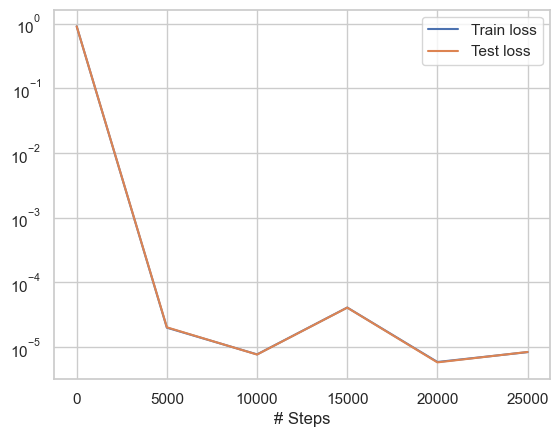

In [497]:
dde.utils.external.plot_loss_history(losshistory)


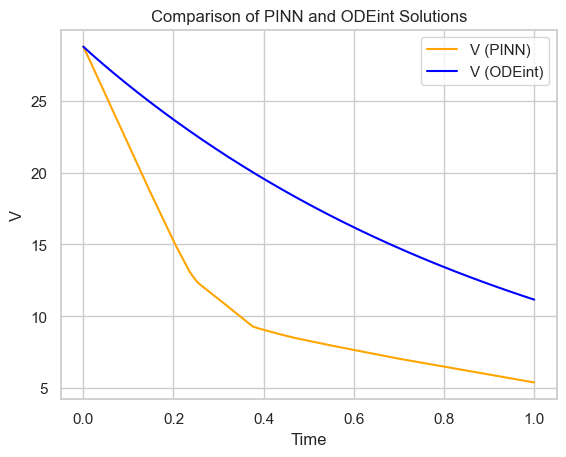

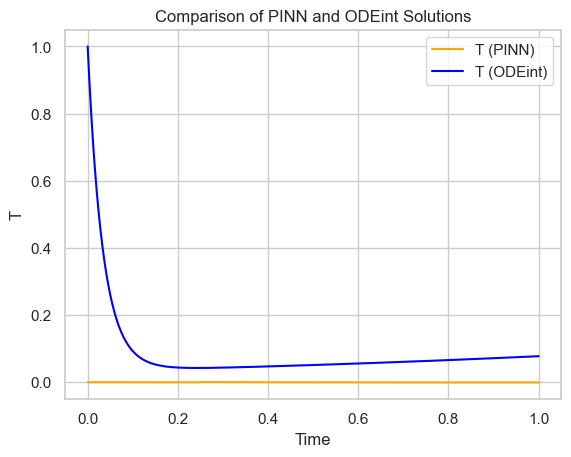

In [498]:

pinn_pred_star = model.predict(tau.reshape(-1, 1))

T_pinn_star = pinn_pred_star[:, 0:1]
I_pinn_star = pinn_pred_star[:, 1:2]
L_pinn_star = pinn_pred_star[:, 2:3]
V_pinn_star = pinn_pred_star[:, 3:4]

# Plot PINN Solution
plt.plot(tau, V_pinn_star, color="orange", label="V (PINN)")

# Plot ODEint Solution
plt.plot(tau, V_star, color="blue", label="V (ODEint)")

# Adding Labels and Title
plt.xlabel("Time")
plt.ylabel("V")
plt.title("Comparison of PINN and ODEint Solutions")

# Adding Legend
plt.legend()

# Adding Grid
plt.grid(True)

# Display the Plot
plt.show()

plt.plot(tau, T_pinn_star, color="orange", label="T (PINN)")
plt.plot(tau, T_star, color="blue", label="T (ODEint)")
plt.xlabel("Time")
plt.ylabel("T")
plt.title("Comparison of PINN and ODEint Solutions")
plt.legend()
plt.grid(True)
plt.show()




In [14]:
# Determine Scaling Factors based on ODEint Solution
T_max, T_min = T.max(), T.min()
I_max, I_min = I.max(), I.min()
L_max, L_min = L.max(), L.min()
V_max, V_min = V.max(), V.min()

scaling_factors = {
    'T': {'max': T_max, 'min': T_min},
    'I': {'max': I_max, 'min': I_min},
    'L': {'max': L_max, 'min': L_min},
    'V': {'max': V_max, 'min': V_min}
}

In [15]:
# Normalization Function
def normalize(y, var):
    return (y - scaling_factors[var]['min']) / (scaling_factors[var]['max'] - scaling_factors[var]['min'])

def denormalize(y_norm, var):
    return y_norm * (scaling_factors[var]['max'] - scaling_factors[var]['min']) + scaling_factors[var]['min']

# Normalize ODEint Solutions
T_norm = normalize(T, 'T')
I_norm = normalize(I, 'I')
L_norm = normalize(L, 'L')
V_norm = normalize(V, 'V')

# Update the func to return normalized values
def func(t):
    T_val = interp_T(t)
    I_val = interp_I(t)
    L_val = interp_L(t)
    V_val = interp_V(t)
    T_norm_val = normalize(T_val, 'T')
    I_norm_val = normalize(I_val, 'I')
    L_norm_val = normalize(L_val, 'L')
    V_norm_val = normalize(V_val, 'V')
    return np.hstack((T_norm_val, I_norm_val, L_norm_val, V_norm_val))

In [16]:
def ode(t, Y):
    T_norm = Y[:, 0:1]
    I_norm = Y[:, 1:2]
    L_norm = Y[:, 2:3]
    V_norm = Y[:, 3:4]
    
    # Denormalize within the ODE for accurate calculations
    T = denormalize(T_norm, 'T')
    I = denormalize(I_norm, 'I')
    L = denormalize(L_norm, 'L')
    V = denormalize(V_norm, 'V')
    
    dT_dt = dde.grad.jacobian(Y, t, i=0) - normalize(lambda_param - d * T - Omega * beta * V * T, 'T')
    dI_dt = dde.grad.jacobian(Y, t, i=1) - normalize((1 - f) * Omega * beta * V * T + a * L - delta_I * I, 'I')
    dL_dt = dde.grad.jacobian(Y, t, i=2) - normalize(f * Omega * beta * V * T - a * L - delta_L * L, 'L')
    dV_dt = dde.grad.jacobian(Y, t, i=3) - normalize(Omega * p * I - c * V, 'V')
    
    return [dT_dt, dI_dt, dL_dt, dV_dt]

# Normalized Initial Conditions
Y0_norm = [
    normalize(T0, 'T'),
    normalize(I0, 'I'),
    normalize(L0, 'L'),
    normalize(V0, 'V')
]

# Update Y0 in data definition
data = dde.data.PDE(
    geom,
    ode,
    [ic_T, ic_I, ic_L, ic_V],
    num_domain=5000,
    num_boundary=2,
    solution=func,
    num_test=1000
)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=25000, display_every=5000)

Compiling model...
'compile' took 0.000217 s

Training model...

0         [1.00e+06, 1.41e+01, 2.41e-01, 1.66e+08, 1.00e+10, 0.00e+00, 0.00e+00, 4.00e+04]    [1.00e+06, 1.41e+01, 2.41e-01, 1.66e+08, 1.00e+10, 0.00e+00, 0.00e+00, 4.00e+04]    []  
5000      [5.91e+06, 2.22e-01, 6.64e-02, 5.17e+05, 4.31e+05, 3.17e+00, 3.87e-01, 1.36e+01]    [5.90e+06, 2.18e-01, 6.67e-02, 5.12e+05, 4.31e+05, 3.17e+00, 3.87e-01, 1.36e+01]    []  
10000     [4.85e+06, 5.06e-01, 2.04e-02, 2.35e+03, 2.80e+02, 1.26e+00, 2.20e-03, 6.83e+00]    [4.84e+06, 4.98e-01, 2.03e-02, 2.32e+03, 2.80e+02, 1.26e+00, 2.20e-03, 6.83e+00]    []  
15000     [3.10e+06, 8.99e-01, 2.54e-02, 1.07e+03, 5.29e+01, 1.30e+00, 6.55e-03, 2.22e+01]    [3.10e+06, 8.93e-01, 2.55e-02, 1.06e+03, 5.29e+01, 1.30e+00, 6.55e-03, 2.22e+01]    []  
20000     [2.60e+06, 1.05e+00, 2.70e-02, 3.47e+03, 1.13e+01, 1.31e+00, 8.03e-03, 2.48e+01]    [2.60e+06, 1.05e+00, 2.71e-02, 3.47e+03, 1.13e+01, 1.31e+00, 8.03e-03, 2.48e+01]    []  
25000     [5.23e+06,

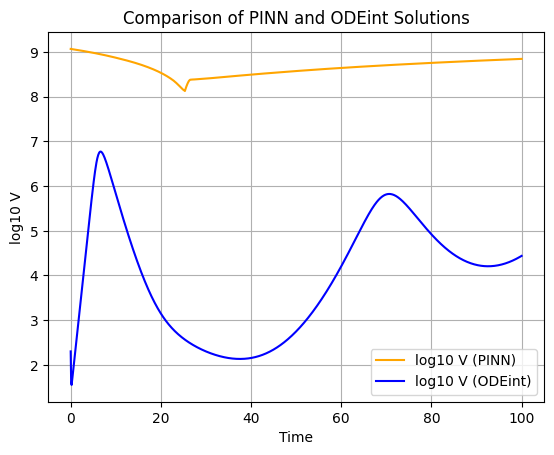

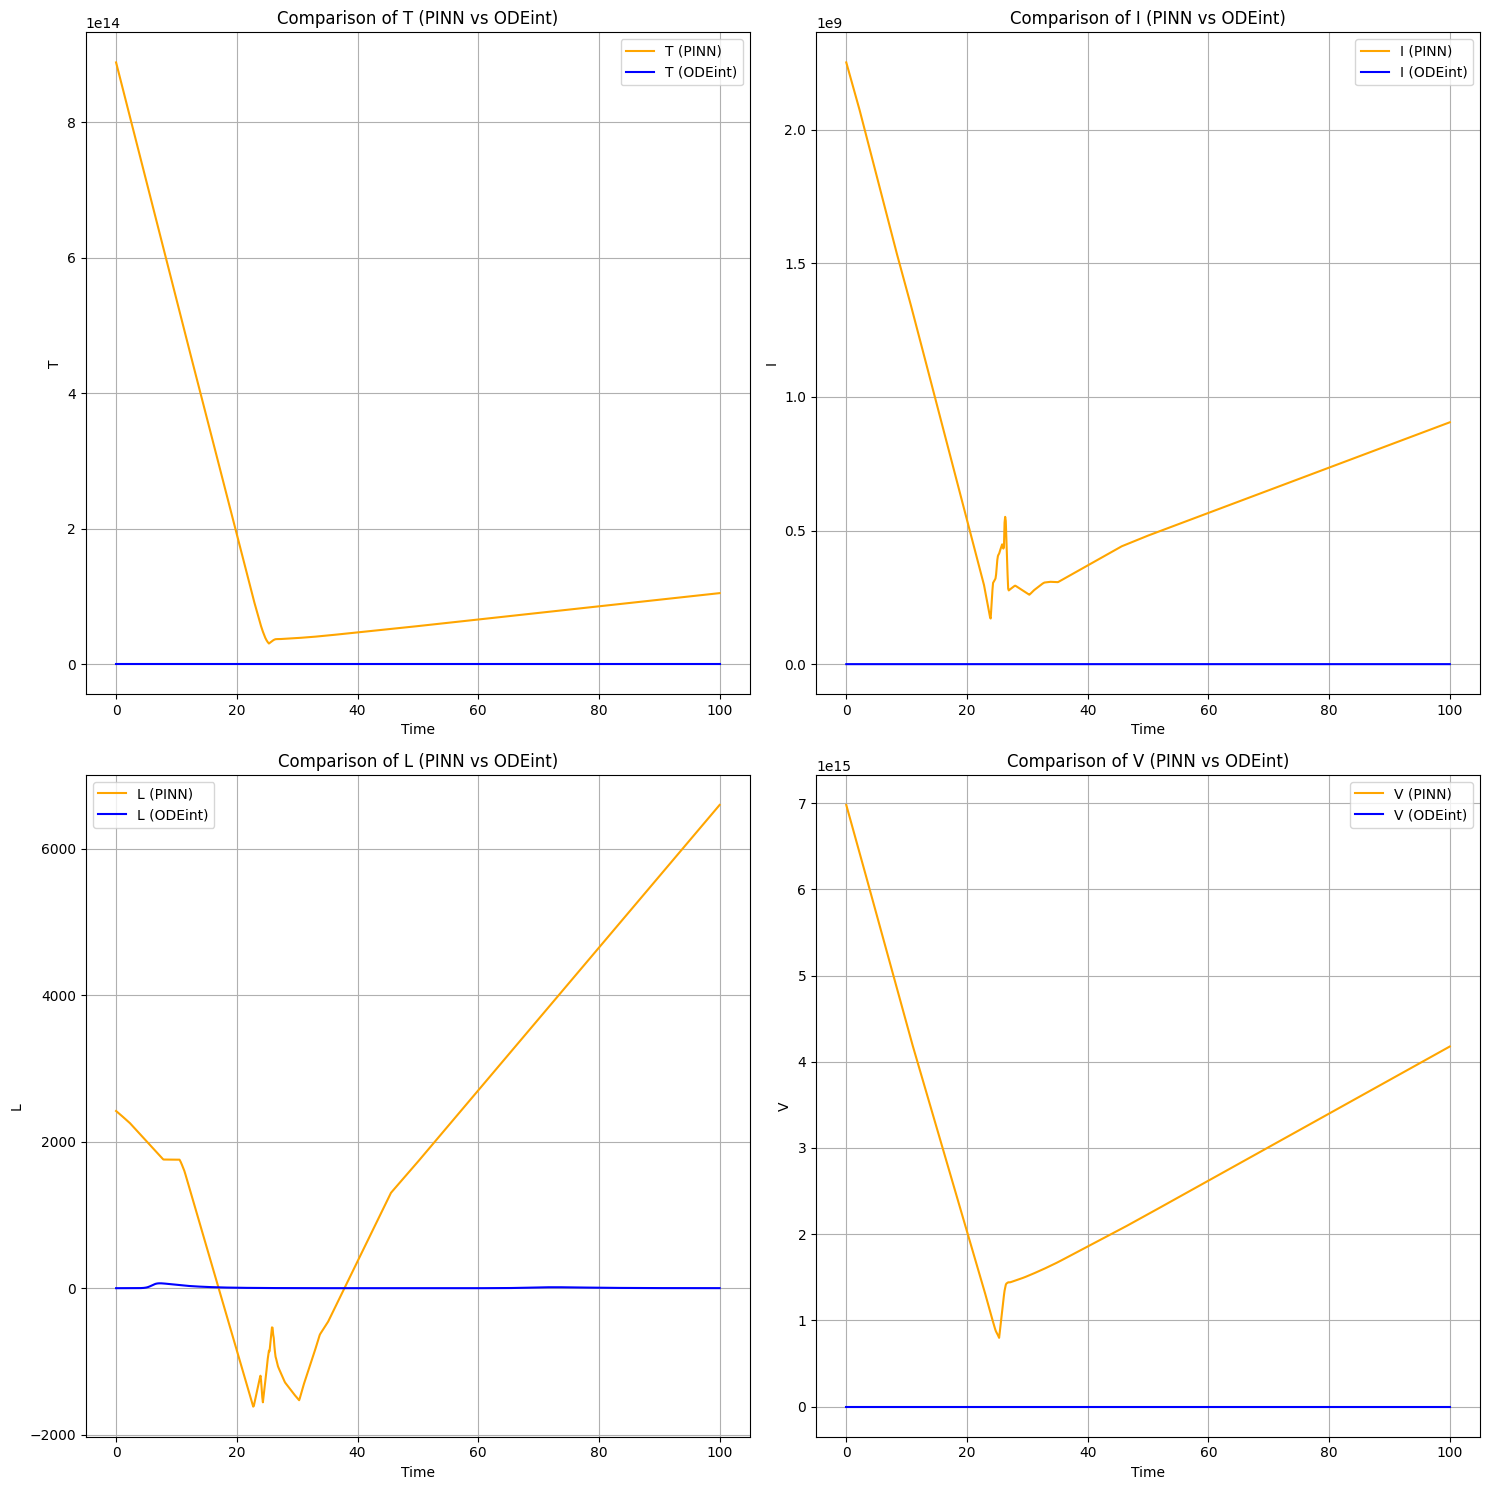

In [17]:
# Predict with PINN (Normalized)
pinn_pred_norm = model.predict(t.reshape(-1, 1))

# Denormalize Predictions
T_pinn = denormalize(pinn_pred_norm[:, 0:1], 'T')
I_pinn = denormalize(pinn_pred_norm[:, 1:2], 'I')
L_pinn = denormalize(pinn_pred_norm[:, 2:3], 'L')
V_pinn = denormalize(pinn_pred_norm[:, 3:4], 'V')

# Plot PINN vs ODEint Solutions (Denormalized)
plt.plot(t, np.log10(V_pinn), color="orange", label="log10 V (PINN)")
plt.plot(t, np.log10(V), color="blue", label="log10 V (ODEint)")
plt.xlabel("Time")
plt.ylabel("log10 V")
plt.title("Comparison of PINN and ODEint Solutions")
plt.legend()
plt.grid(True)
plt.show()

# Denormalize All Predictions for Subplots
T_pinn_denorm = denormalize(T_pinn, 'T')
I_pinn_denorm = denormalize(I_pinn, 'I')
L_pinn_denorm = denormalize(L_pinn, 'L')
V_pinn_denorm = denormalize(V_pinn, 'V')

# Create a 2x2 grid of subplots with Denormalized Data
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

variables_denorm = [T_pinn_denorm, I_pinn_denorm, L_pinn_denorm, V_pinn_denorm]
odeint_variables_denorm = [T, I, L, V]
titles = ['T', 'I', 'L', 'V']

for i, (pinn_var, odeint_var, title) in enumerate(zip(variables_denorm, odeint_variables_denorm, titles)):
    axs[i].plot(t, pinn_var, color="orange", label=f"{title} (PINN)")
    axs[i].plot(t, odeint_var, color="blue", label=f"{title} (ODEint)")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(title)
    axs[i].set_title(f"Comparison of {title} (PINN vs ODEint)")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [9]:
import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint
import math
import pandas as pd
from io import StringIO
from scipy.interpolate import interp1d

# =======================
# **1. Import Libraries and Define Parameters**
# =======================

# Initial Conditions
T0 = 100000  # Initial Temperature
I0 = 0       # Initial Infected
L0 = 0       # Initial Latent
V0 = 200     # Initial Virus Count

# Parameters
d = 0.01
beta = 0.0000002
f = 0.001
a = 0.2
delta_I = 1 
delta_L = 0.0039
c = 23
p = 4000
lambda_param = 1000  # T0 * d
Omega = 1

# Time Domain
t_initial = 0
t_final = 100
num_points = 1000
t = np.linspace(t_initial, t_final, num_points)

# =======================
# **2. Solve ODE System Numerically for T, I, L**
# =======================

# Define the ODE system for T, I, L
def system_TIY(Y, t):
    T, I, L = Y
    dT_dt = lambda_param - d * T - Omega * beta * V_solution_interp(t) * T
    dI_dt = (1 - f) * Omega * beta * V_solution_interp(t) * T + a * L - delta_I * I
    dL_dt = f * Omega * beta * V_solution_interp(t) * T - a * L - delta_L * L
    return [dT_dt, dI_dt, dL_dt]

# Placeholder for V(t), will be updated after solving V with PINN
# For initial numerical solution, assume V(t) is constant (can be improved iteratively)
V_initial_guess = V0 * np.ones_like(t)

# Interpolation function for V(t)
V_solution_interp = interp1d(t, V_initial_guess, kind='cubic', fill_value='extrapolate')

# Solve ODE for T, I, L with initial guess for V
Y0 = [T0, I0, L0]
solution_TI = odeint(system_TIY, Y0, t)
T, I, L = solution_TI.T

# =======================
# **3. Update V(t) Interpolation with PINN Later**
# =======================

# At this point, we have initial solutions for T, I, L
# We'll proceed to define a PINN to learn V(t) given T(t), I(t), L(t)

# =======================
# **4. Define Scaling for V(t)**
# =======================

# Scaling Parameters for V
V_ref = 40000  # Reference scale for V to normalize
V_norm = V0 / V_ref  # Normalized initial V

# Normalize V data
V_normalized = V_initial_guess / V_ref

# =======================
# **5. Define the PINN for V(t)**
# =======================

# Geometry
geom = dde.geometry.TimeDomain(t_initial, t_final)

# Define the ODE for V: dV/dt = Omega * p * I - c * V
def ode_V(t, V):
    """Physics-informed neural network ODE for V."""
    V_derivative = dde.grad.jacobian(V, t)
    I_current = interp1d(t, I, kind='cubic', fill_value='extrapolate')(t)
    return V_derivative - (Omega * p * I_current - c * V)

# Boundary Condition: Initial condition for V
def boundary(_, on_initial):
    return on_initial

ic_V = dde.icbc.IC(geom, lambda x: V_norm, boundary, component=0)

# Prepare training data
data = dde.data.PDE(
    geom,
    ode_V,
    [ic_V],
    num_domain=5000,
    num_boundary=1,
    solution=lambda t: V_normalized.reshape(-1, 1),
    num_test=1000
)

# Define the neural network
neurons = 64
layers = 3
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [neurons] * layers + [1], activation, initializer)

# Create the model
model = dde.Model(data, net)

# Compile the model
model.compile("adam", lr=0.001)

# =======================
# **6. Train the PINN Model**
# =======================

losshistory, train_state = model.train(iterations=20000, display_every=5000)

# Plot loss history
dde.utils.external.plot_loss_history(losshistory)
plt.show()

# =======================
# **7. Predict V(t) with PINN**
# =======================

# Predict normalized V(t)
V_pinn_normalized = model.predict(t.reshape(-1, 1)).flatten()

# Denormalize V(t)
V_pinn = V_pinn_normalized * V_ref

# Update the interpolation function for V(t)
V_solution_interp = interp1d(t, V_pinn, kind='cubic', fill_value='extrapolate')

# =======================
# **8. Re-solve ODE for T, I, L with Updated V(t)**
# =======================

# Redefine the ODE system with updated V(t)
def system_TIY_updated(Y, t):
    T, I, L = Y
    V_current = V_solution_interp(t)
    dT_dt = lambda_param - d * T - Omega * beta * V_current * T
    dI_dt = (1 - f) * Omega * beta * V_current * T + a * L - delta_I * I
    dL_dt = f * Omega * beta * V_current * T - a * L - delta_L * L
    return [dT_dt, dI_dt, dL_dt]

# Solve ODE with updated V(t)
solution_TI_updated = odeint(system_TIY_updated, Y0, t)
T, I, L = solution_TI_updated.T

# =======================
# **9. Update V(t) with New PINN Training (Optional)**
# =======================

# Optionally, iterate between solving ODE and training PINN for better accuracy
# This step can be repeated as needed

# =======================
# **10. Plot Comparison of PINN and ODEint Solutions for V(t)**
# =======================

# Numerical solution for V(t) using ODEint
def system_V(Y, t):
    return Omega * p * I_solution_interp(t) - c * Y

# Interpolation for I(t)
I_solution_interp = interp1d(t, I, kind='cubic', fill_value='extrapolate')

# Solve V(t) numerically
V_numerical = odeint(system_V, V0, t).flatten()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, V_pinn, label="V (PINN)", color="orange")
plt.plot(t, V_numerical, label="V (ODEint)", linestyle='--', color="blue")
plt.xlabel("Time")
plt.ylabel("V")
plt.title("Comparison of PINN and ODEint Solutions for V(t)")
plt.legend()
plt.grid(True)
plt.show()

# =======================
# **11. Save Results to CSV**
# =======================

# Create a DataFrame with results
df_results = pd.DataFrame({
    "Time": t,
    "V_PINN": V_pinn,
    "V_ODEint": V_numerical
})

# =======================
# **End of Script**
# =======================

ValueError: x and y arrays must be equal in length along interpolation axis.

Compiling model...
'compile' took 0.000234 s

Training model...

0         [3.47e-01]                                                                          [3.02e-01]                                                                          [1.20e+00]
1000      [3.03e-04]                                                                          [2.88e-04]                                                                          [3.71e-02]
2000      [6.42e-05]                                                                          [1.09e-04]                                                                          [2.28e-02]
3000      [1.45e-05]                                                                          [6.76e-05]                                                                          [1.80e-02]
4000      [7.86e-06]                                                                          [5.78e-05]                                                                          [

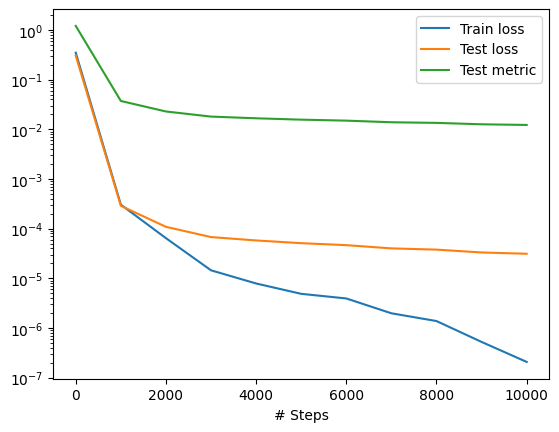

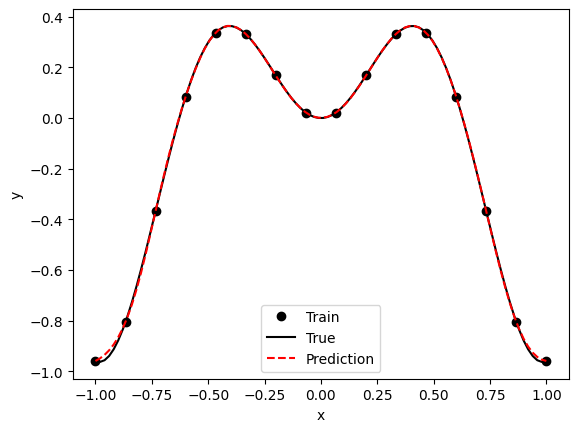

In [10]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np


def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return x * np.sin(5 * x)


geom = dde.geometry.Interval(-1, 1)
num_train = 16
num_test = 100
data = dde.data.Function(geom, func, num_train, num_test)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [20] * 3 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)